
<font size="5">
    This notebook covers some common operations and transformations applied to Big Data using Apache Spark.
    </font>
<br>
<br>
This notebook was exectuted on AWS Amazon EMR.
<br>

In [ ]:
%%configure -f 
{"driverMemory": "6000M",
"conf":{
          "spark.pyspark.python": "python",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

In [1]:
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
23,application_1598894905645_0024,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/f1/b9/712584f12f840968a14969a1fe298ffdeaa9c4b484b3bfd973c74c4a481d/matplotlib-3.3.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226f0b4e0bb042e4dc13483228b4718baf286f86d87/certifi-2020.6.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/f2/6722dd0c22e3a143ac792ccb2424924ac72af4adea756b1165b4cad50da7/Pillow-7.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached htt

In [2]:
import csv
import random
import string
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

print("Starting...")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Starting...

## Generate Data

The data generation code was adapted from https://gist.github.com/aialenti/cfd4e213ebf2ef6e20b195c8fb45382c

In [ ]:
#run only on the first time executing the code

sc.install_pypi_package("pandas")
sc.install_pypi_package("tqdm")

import pandas as pd
from tqdm import tqdm
import csv
import random
import string
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

random.seed(1999)

letters = string.ascii_lowercase
letters_upper = string.ascii_uppercase
for _i in range(0, 10):
    letters += letters

for _i in range(0, 10):
    letters += letters_upper


def random_string(stringLength=10):
    """Generate a random string of fixed length """
    return ''.join(random.sample(letters, stringLength))


n_products = 750000
print("Products between {} and {}".format(1, n_products))
product_ids = [x for x in range(1, n_products)]
dates = ['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
         '2020-07-09', '2020-07-10']
seller_ids = [x for x in range(1, 10)]


#   Generate products
products = [[0, "product_0", 22]]
for p in tqdm(product_ids):
    products.append([p, "product_{}".format(p), random.randint(1, 150)])

#   Save dataframe
mySchema = StructType([ StructField("product_id", LongType(), True)\
                       ,StructField("product_name", StringType(), True)\
                       ,StructField("price", IntegerType(), True)])

df = spark.createDataFrame(products,schema=mySchema)
df.write.save('hdfs:///products/', format="parquet", mode="overwrite")

del df
del products

print("Products Done")


#   Generate sellers
n_sellers = 25000
sellers = [[0, "seller_0", n_sellers]]
for s in tqdm(seller_ids):
    sellers.append([s, "seller_{}".format(s), random.randint(1200, n_sellers)])

#   Save dataframe
mySchema = StructType([ StructField("seller_id", LongType(), True)\
                       ,StructField("seller_name", StringType(), True)\
                       ,StructField("daily_target", IntegerType(), True)])

df = spark.createDataFrame(sellers,schema=mySchema)
df.write.save('hdfs:///sellers/', format="parquet", mode="overwrite")


print("Sellers Done")

#   Generate sales
total_rows = 10000
prod_zero = int(total_rows * 0.95)
prod_others = total_rows - prod_zero + 1

df_array = [[]]

mySchema = StructType([ StructField("order_id", LongType(), True)\
                       ,StructField("product_id", LongType(), True)\
                       ,StructField("seller_id", LongType(), True)
                       ,StructField("date", StringType(), True)\
                       ,StructField("num_pieces_sold", IntegerType(), True)\
                       ,StructField("bill_raw_text", StringType(), True)])

order_id = 0
df_array = []
for i in tqdm(range(0, 40)):
    

    for i in range(0, prod_zero):
        order_id += 1
        df_array.append([order_id, 0, 0, random.choice(dates), random.randint(1, 100), random_string(500)])

    
    for i in range(0, prod_others):
        order_id += 1
        df_array.append(
            [order_id, random.choice(product_ids), random.choice(seller_ids), random.choice(dates),
             random.randint(1, 100), random_string(500)])

    
        
df = spark.createDataFrame(df_array,schema=mySchema)
df.write.save('hdfs:///sales/', format="parquet", mode="overwrite")



In [3]:
#Load data
products_df = spark.read.parquet("hdfs:///products")
sales_df = spark.read.parquet("hdfs:///sales")
sellers_df = spark.read.parquet("hdfs:///sellers")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Initial Data Analysis

## Products

In [4]:
products_df = products_df.withColumn("price", products_df["price"].cast(IntegerType()))
products_df.show(10)

products_df.printSchema()

products_df.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------+-----+
|product_id|  product_name|price|
+----------+--------------+-----+
|    374784|product_374784|  131|
|    374785|product_374785|  100|
|    374786|product_374786|   92|
|    374787|product_374787|   13|
|    374788|product_374788|   94|
|    374789|product_374789|   90|
|    374790|product_374790|  114|
|    374791|product_374791|   64|
|    374792|product_374792|   58|
|    374793|product_374793|   46|
+----------+--------------+-----+
only showing top 10 rows

root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: integer (nullable = true)

+-------+------------------+-------------+------------------+
|summary|        product_id| product_name|             price|
+-------+------------------+-------------+------------------+
|  count|            750000|       750000|            750000|
|   mean|          374999.5|         null| 75.43187466666667|
| stddev|216506.49528362884|         null|43.275723510107916

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

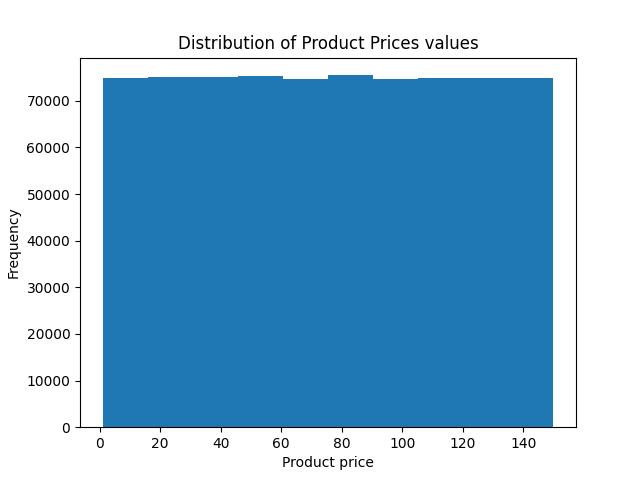

In [5]:
bins, counts = products_df.rdd.map(lambda x : x[2]).histogram(10)
plt.clf()

plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of Product Prices values')
plt.xlabel('Product price')
plt.ylabel('Frequency')
#plt.show()

%matplot plt

## Orders

In [6]:
sales_df = sales_df.withColumn("num_pieces_sold", sales_df["num_pieces_sold"].cast(IntegerType()))
sales_df = sales_df.withColumn("date", sales_df["date"].cast(DateType()))

sales_df.show(10)

sales_df.printSchema()

sales_df.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+----------+---------+----------+---------------+--------------------+
|order_id|product_id|seller_id|      date|num_pieces_sold|       bill_raw_text|
+--------+----------+---------+----------+---------------+--------------------+
|       1|         0|        0|2020-07-09|             58|snsoxpkswdasbcnup...|
|       2|         0|        0|2020-07-10|             92|csqibsokudgpmfblz...|
|       3|         0|        0|2020-07-08|              9|dcthhiychddkdumdd...|
|       4|         0|        0|2020-07-01|             44|vhkjxgonfuhctbhnp...|
|       5|         0|        0|2020-07-07|             79|frmqbeghxuehzwwph...|
|       6|         0|        0|2020-07-02|             23|gqrraskhzoanzrcsq...|
|       7|         0|        0|2020-07-04|             90|xaksoxntutnhsjmxs...|
|       8|         0|        0|2020-07-10|             80|jatumxtcjospvbtxa...|
|       9|         0|        0|2020-07-09|             53|peqoriydwbdwuowoz...|
|      10|         0|        0|2020-07-0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

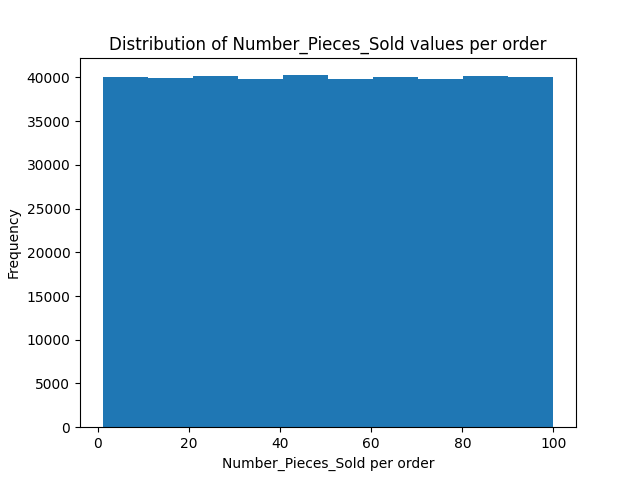

In [7]:
bins, counts = sales_df.rdd.map(lambda x : x[4]).histogram(10)
plt.clf()

plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of Number_Pieces_Sold values per order')
plt.xlabel('Number_Pieces_Sold per order')
plt.ylabel('Frequency')
#plt.show()

%matplot plt



## Sellers

In [8]:
sellers_df = sellers_df.withColumn("daily_target", sellers_df["daily_target"].cast(IntegerType()))

sellers_df.show(10)

sellers_df.printSchema()

sellers_df.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+------------+
|seller_id|seller_name|daily_target|
+---------+-----------+------------+
|        6|   seller_6|       20341|
|        7|   seller_7|        1808|
|        8|   seller_8|        8211|
|        9|   seller_9|        3333|
|        0|   seller_0|       25000|
|        1|   seller_1|       13818|
|        4|   seller_4|       20283|
|        5|   seller_5|       15190|
|        2|   seller_2|       19552|
|        3|   seller_3|       12059|
+---------+-----------+------------+

root
 |-- seller_id: long (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- daily_target: integer (nullable = true)

+-------+------------------+-----------+-----------------+
|summary|         seller_id|seller_name|     daily_target|
+-------+------------------+-----------+-----------------+
|  count|                10|         10|               10|
|   mean|               4.5|       null|          13959.5|
| stddev|3.0276503540974917|       null|7693.08239408

**Some informations extracted by crossing the product_id of the different tables**

In [9]:
print('Number of Products:' , products_df.count())
print('Number of Orders:' , sales_df.count())
print('Number of Sellers:' , sellers_df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Products: 750000
Number of Orders: 400040
Number of Sellers: 10

In [10]:
#Number of products sold at least one time
sales_df.agg(countDistinct(col("product_id"))).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     19777|
+--------------------------+

In [11]:
#Number of orders with each product_id

sales_df.groupBy(col("product_id")).agg(
    count("*").alias("cnt")).orderBy(col("cnt").desc()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+
|product_id|   cnt|
+----------+------+
|         0|380000|
|    131083|     3|
|    125565|     3|
|    707407|     3|
|    250717|     2|
|    492174|     2|
|    274003|     2|
|    570404|     2|
|    508981|     2|
|    201899|     2|
|    536023|     2|
|    715675|     2|
|    420434|     2|
|    412285|     2|
|    323626|     2|
|    240171|     2|
|    420624|     2|
|    142531|     2|
|    541334|     2|
|    693301|     2|
+----------+------+
only showing top 20 rows

As we can see, the first product (product_id = 0) was sold in almost 2M of the orders. This means, that the major part of the orders were done with respect to product 0.

# Questions to be answered using the data

Questions were made based on https://towardsdatascience.com/six-spark-exercises-to-rule-them-all-242445b24565

 **Question 1: How many distinct products have been sold in each date?**

In [12]:
#Answer
sales_df.groupBy(col("date"))\
    .agg(countDistinct(col("product_id")).alias("n_products_sold"))\
    .orderBy(col("n_products_sold").desc()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+
|      date|n_products_sold|
+----------+---------------+
|2020-07-04|           2054|
|2020-07-06|           2025|
|2020-07-09|           2023|
|2020-07-01|           2017|
|2020-07-05|           2011|
|2020-07-07|           2004|
|2020-07-03|           1996|
|2020-07-02|           1980|
|2020-07-08|           1962|
|2020-07-10|           1944|
+----------+---------------+

**Question 2: What is the average revenue of the orders?**

In [13]:
#Initial Solution

sales_df.join(products_df, sales_df["product_id"] == products_df["product_id"], "inner")\
    .agg(avg(products_df["price"] * sales_df["num_pieces_sold"])).show()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+
|avg((price * num_pieces_sold))|
+------------------------------+
|             1244.911796320368|
+------------------------------+

NOTE: As we saw earlier, the number of each type of products that are sold have a very skewed distribution, as the majority of the sales are with regards to product_0. This will mean that the partition associated with the sales data regarding product_0 will take much longer to execute than others (as the size of data is significantly bigger). This can be seen in the Spark UI.

To solve this problem, a re-labelling of product_0 can be performed by creating sublabels of product_0, like product_0-1, product_0-2, product_0-3, .... This will level the quantity of data between the different products (as product_0 is divided into the sublabels). As the data concerning the different labels (product_0-1, product_0-2, ...) will go to different partitions, the total work and processing will be more equally paralelized, therefore decreasing the global execution time.

**Question 3: For each seller, what is the average % contribution of an order to the sellers’ daily quota?**

In [14]:
sales_df.join(sellers_df, sales_df["seller_id"] == sellers_df["seller_id"], "inner")\
    .withColumn("perc_target", sales_df["num_pieces_sold"]/sellers_df["daily_target"])\
    .groupby(sellers_df["seller_id"]).agg(avg("perc_target")).show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|seller_id|    avg(perc_target)|
+---------+--------------------+
|        5|0.003297049749522487|
|        6|0.002463949622538975|
|        9|0.015227195969147999|
|        1|0.003601570720012...|
|        3|0.004047099652244278|
|        2|0.002558954126517...|
|        0|0.002021594631579...|
|        7| 0.02786297583608452|
|        8|0.006021404728495171|
|        4|0.002482820221524996|
+---------+--------------------+

This case is similar to the above, although in this case, as the sellers_df is a smaller dataframe, a **broadcast** join will be performed. Thus, the join operation will be much fast, as a data partition reshuffling will not be neeeded.

**Question 4: Who are the second most selling and the least selling persons (sellers) for each product**

For that, window aggregation functions will be used

In [15]:

#compute money spent by each seller, in each product
new_df = sales_df.join(products_df, sales_df["product_id"] == products_df["product_id"], "inner")\
    .withColumn("total", products_df["price"] * sales_df["num_pieces_sold"])\
    .groupby(sales_df["product_id"], sales_df["seller_id"]).agg(sum("total").alias("total"))


#window aggregation function
window_func_asc = Window.partitionBy("product_id").orderBy(new_df["total"].desc())
window_func_desc = Window.partitionBy("product_id").orderBy(new_df["total"].asc())

#add Rank column
new_df_asc = new_df.withColumn("rank",rank().over(window_func_asc))
new_df_desc = new_df.withColumn("rank",rank().over(window_func_desc))

#retrive the 2nd best
df_2_best = new_df_asc.filter("rank=2")

#retrive the 1st least
df_1_least = new_df_desc.filter("rank=1")


df_2_best.show()
df_1_least.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+-----+----+
|product_id|seller_id|total|rank|
+----------+---------+-----+----+
|    110070|        7| 1768|   2|
|    112309|        9|  637|   2|
|    311008|        7| 1224|   2|
|    420547|        6|  578|   2|
|    527557|        4| 1120|   2|
|    646338|        9| 3363|   2|
|    666855|        1|10935|   2|
|     49238|        3| 1127|   2|
|     74826|        3| 4590|   2|
|    143326|        1|  966|   2|
|    253214|        6|   99|   2|
|    314171|        3| 7865|   2|
|    314260|        8| 4859|   2|
|    554070|        6| 4305|   2|
|    561949|        5|  779|   2|
|    634738|        9| 8526|   2|
|    634743|        6| 1326|   2|
|    700866|        5| 1763|   2|
|    705407|        8| 5292|   2|
|    125565|        1| 2450|   2|
+----------+---------+-----+----+
only showing top 20 rows

+----------+---------+-----+----+
|product_id|seller_id|total|rank|
+----------+---------+-----+----+
|       876|        5|  630|   1|
|      2378|        3|

**Question 5: Is the seller_name always aligned with the seller_id?**

Example: name: seller_1 -> id: 1

In this solution a UDF will be used

In [16]:

def get_id(s, i):
    split_col = s.split('_')
    print(split_col)
    
    if str(i) == split_col[-1]:
        return 1
    else:
        return 0

get_id_udf = udf(get_id, IntegerType())
spark.udf.register("get_Id_from_Name", get_id_udf)

new_sellers_df = sellers_df.withColumn('verification', get_id_udf('seller_name', 'seller_id'))
new_sellers_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+------------+------------+
|seller_id|seller_name|daily_target|verification|
+---------+-----------+------------+------------+
|        6|   seller_6|       20341|           1|
|        7|   seller_7|        1808|           1|
|        8|   seller_8|        8211|           1|
|        9|   seller_9|        3333|           1|
|        0|   seller_0|       25000|           1|
|        1|   seller_1|       13818|           1|
|        4|   seller_4|       20283|           1|
|        5|   seller_5|       15190|           1|
|        2|   seller_2|       19552|           1|
|        3|   seller_3|       12059|           1|
+---------+-----------+------------+------------+